# 🚦 Dangerous Intersection Detector – RiverHacks 2025 Project

## 📌 Project Overview
This notebook is part of a hackathon project for RiverHacks 2025, focused on public safety in Austin, Texas. Using real-world crash and infrastructure data from the City of Austin Open Data Portal, we aim to analyze traffic incidents and identify intersections with high crash severity.

By processing, enriching, and analyzing crash data, we will identify dangerous intersections and later integrate this work into a web application powered by Flask and webAI Navigator.

---

## 🎯 Project Objective
Our main objective is to detect and rank **high-risk intersections** based on historical crash data. We will:
- Clean and preprocess Austin crash records
- Create a custom **Danger Score** that prioritizes fatal and severe crashes
- Use clustering and/or machine learning to analyze patterns
- Build a web application that visualizes the results and allows for interactive exploration

---



## ✅ Step 1: Crash Data Summary

We are working with crash-level records from the City of Austin Open Data Portal. The dataset includes thousands of crash reports with:
- Timestamps
- Coordinates (latitude, longitude)
- Number of deaths and injuries
- Street and intersection info

We'll first explore the structure of the data before cleaning.


In [10]:
import pandas as pd

# Load the dataset
crash_df = pd.read_csv(
    "../data/Austin_Crash_Report_Data_-_Crash_Level_Records_20250424.csv",
    dtype={"rpt_block_num": str, "rpt_street_sfx": str},
    low_memory=False
)

crash_df.info()
crash_df.describe()
crash_df.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217159 entries, 0 to 217158
Data columns (total 45 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    217159 non-null  int64  
 1   Crash ID                              217154 non-null  float64
 2   crash_fatal_fl                        217159 non-null  bool   
 3   case_id                               214245 non-null  object 
 4   Primary address                       217159 non-null  object 
 5   Secondary address                     217157 non-null  object 
 6   rpt_block_num                         187949 non-null  object 
 7   rpt_street_name                       217158 non-null  object 
 8   rpt_street_sfx                        149882 non-null  object 
 9   crash_speed_limit                     217155 non-null  float64
 10  road_constr_zone_fl                   217154 non-null  object 
 11  

Reported street prefix                  217159
rpt_street_sfx                           67277
rpt_block_num                            29210
point                                     3459
longitude                                 3459
latitude                                  3458
case_id                                   2914
road_constr_zone_fl                          5
Crash ID                                     5
crash_speed_limit                            4
Secondary address                            2
rpt_street_name                              1
Primary address                              0
crash_fatal_fl                               0
ID                                           0
nonincap_injry_cnt                           0
crash_sev_id                                 0
non_injry_cnt                                0
unkn_injry_cnt                               0
tot_injry_cnt                                0
sus_serious_injry_cnt                        0
death_cnt    

### 📊 Observation — Crash Dataset Overview

- The dataset contains **217,159 crash-level records** with **45 columns**, including timestamps, coordinates, severity measures, and street information.
- Most critical fields such as `latitude`, `longitude`, `tot_injry_cnt`, and `death_cnt` are fully populated.
- Some non-critical fields like `rpt_block_num`, `rpt_street_sfx`, and `case_id` contain missing values, but these will not affect our core analysis.
- This dataset offers rich temporal and spatial detail, making it suitable for crash density and risk prediction.


## 🧮 Visualizing Crash Fatality Distribution

Before diving into data cleaning, it's useful to visualize the overall severity of crashes.

This bar chart shows the distribution of crashes by the number of reported deaths (`death_cnt`). It helps us quickly assess how frequent fatal crashes are compared to non-fatal ones.


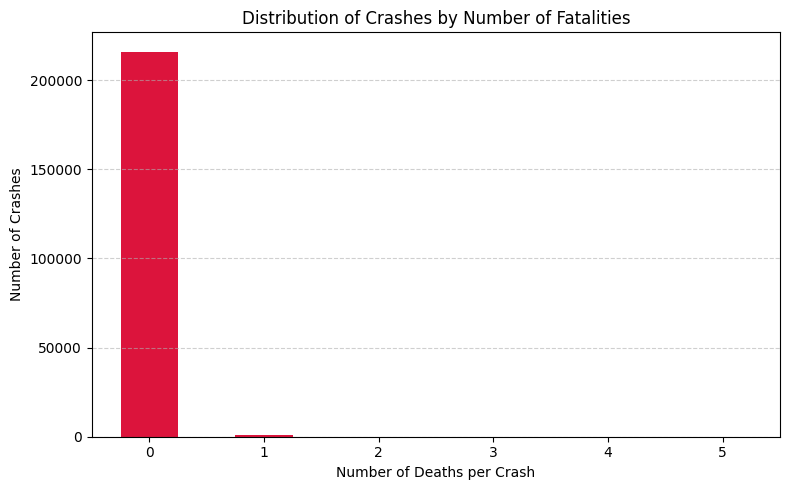

In [11]:
import matplotlib.pyplot as plt

# Count how many crashes involved each number of deaths
death_distribution = crash_df["death_cnt"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
death_distribution.plot(kind="bar", color="crimson")
plt.title("Distribution of Crashes by Number of Fatalities")
plt.xlabel("Number of Deaths per Crash")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### 📊 Observation — Crash Fatality Distribution

- The vast majority of crashes involved **zero fatalities**, confirming that most incidents are non-lethal.
- A very small fraction of crashes involved **1 or more deaths**, highlighting the **rarity of fatal incidents** but also their potential severity.
- This skewed distribution will be important when building predictive models, especially in addressing **class imbalance**.


## 🧮 Visualizing Crash Injury Distribution

To complement the fatality analysis, this chart displays the distribution of crashes by the **total number of reported injuries** (`tot_injry_cnt`). Unlike fatalities, injuries are far more frequent and vary more across crashes.

This helps us understand how often people are harmed in crashes, even when fatalities are rare.


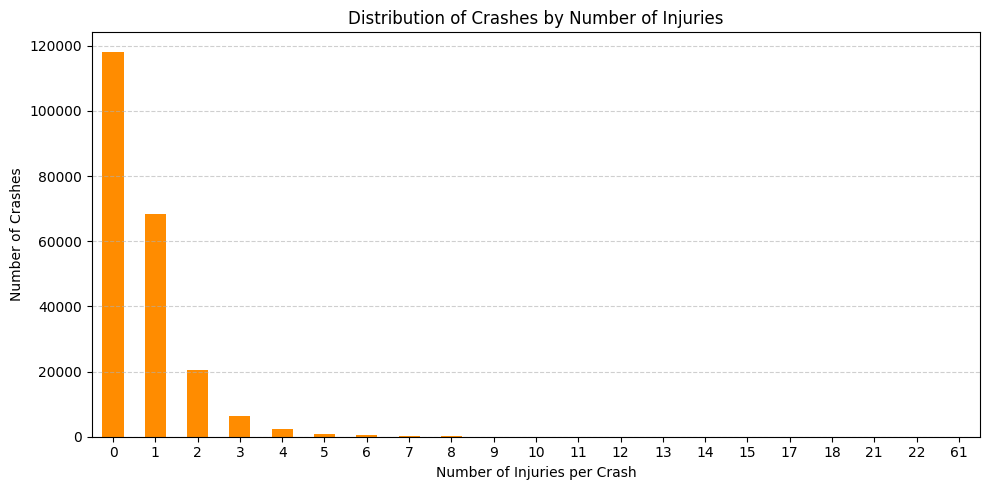

In [12]:
# Count how many crashes involved each number of injuries (total injury count)
injury_distribution = crash_df["tot_injry_cnt"].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
injury_distribution.plot(kind="bar", color="darkorange")
plt.title("Distribution of Crashes by Number of Injuries")
plt.xlabel("Number of Injuries per Crash")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### 📊 Observation — Crash Injury Distribution

- Most crashes involve **zero or one injury**, but the distribution has a **long tail**, with some crashes involving many injuries.
- Unlike fatalities, injury counts show more variability, making this a **stronger signal** for identifying dangerous locations.
- This visualization supports the need to include **injury severity** in our danger scoring and ML models.


## ✅ Step 2: Clean and Prepare the Crash Dataset

### In this step, we will:
1. **Load the crash dataset** from the downloaded CSV file.
2. **Remove rows with missing latitude or longitude**, since spatial analysis depends on geographic accuracy.
3. **Standardize the crash timestamp** column to ensure consistent datetime formatting.
4. **Remove invalid timestamps**, if any, that couldn't be parsed.
5. **Create a `danger_score` column**, calculated as:
danger_score = death_cnt * 5 + tot_injry_cnt

This formula gives higher importance to fatal crashes while still considering total injury count.

This cleaned and enriched dataset will serve as the foundation for the rest of the analysis and model development.

In [14]:
# 1. Drop rows with missing latitude or longitude
crash_df = crash_df.dropna(subset=["latitude", "longitude"])

# 2. Convert crash timestamp to datetime format
crash_df["Crash timestamp"] = pd.to_datetime(crash_df["Crash timestamp"], errors="coerce")

# 3. Drop rows with invalid or unparsable timestamps
crash_df = crash_df.dropna(subset=["Crash timestamp"])

# 4. Create a new column: danger_score = death_cnt * 5 + tot_injry_cnt
crash_df["danger_score"] = crash_df["death_cnt"] * 5 + crash_df["tot_injry_cnt"]

# Show a sample of the cleaned and prepared data
crash_df[["latitude", "longitude", "Crash timestamp", "death_cnt", "tot_injry_cnt", "danger_score"]].head()


,latitude,longitude,Crash timestamp,death_cnt,tot_injry_cnt,danger_score
4,30.244344,-97.781309,2014-01-08 19:35:00,0,4,4
5,30.280295,-97.740912,2014-01-19 11:31:00,0,0,0
6,30.216696,-97.848713,2014-01-08 20:30:00,0,0,0
7,30.183030,-97.794860,2014-01-19 05:04:00,0,0,0
8,30.182598,-97.847707,2014-01-22 14:34:00,0,1,1


## ✅ Observation: Cleaned Crash Data with Danger Score

The dataset has been successfully cleaned and enriched:

- All rows now contain valid **latitude and longitude**, allowing for accurate spatial analysis.
- The `Crash timestamp` has been standardized into a uniform datetime format.
- A new column, `danger_score`, was created using the formula:
danger_score = death_cnt * 5 + tot_injry_cnt

This score prioritizes fatal incidents (with a weight of 5) while still incorporating total injury count.

From the preview:
- Some incidents have **non-zero danger scores**, such as the first row with a score of 4 (no deaths, 4 injuries).
- Others have a score of 0, indicating either no reported injuries or non-severe incidents.

This enriched dataset is now ready for spatial grouping, clustering, and further feature engineering.


In [ ]:
# Save the cleaned and enriched crash-level dataset
crash_df.to_csv("crash_data_cleaned.csv", index=False)

## Step 3: Group by Grid Cell for Location-Based Aggregation

Instead of relying on intersection names (which can be inconsistent or missing), we will group crash locations into uniform **spatial grid cells** based on latitude and longitude.

### Why Use Grids?
- Not all crash records have consistent street names or intersection IDs.
- Using fixed-size grids (e.g., ~100m) allows us to **cluster nearby incidents** and spot dangerous areas more reliably.

### What We'll Do:
1. Define a grid size (e.g., round latitude/longitude to 3 decimal places ≈ ~100m radius)
2. Create new columns: `lat_grid`, `lon_grid`
3. Group by `(lat_grid, lon_grid)` and aggregate:
   - Total crashes
   - Sum of `danger_score`
   - Optional: average timestamp for time-based insights
4. Display top 10 most dangerous grid cells

This will prepare us for mapping and hotspot detection.


In [15]:
# 1. Create lat/lon grid columns rounded to 3 decimal places (~100m spatial granularity)
crash_df["lat_grid"] = crash_df["latitude"].round(3)
crash_df["lon_grid"] = crash_df["longitude"].round(3)

# 2. Group by the grid cells
grid_summary = crash_df.groupby(["lat_grid", "lon_grid"]).agg(
    total_crashes=("danger_score", "count"),
    total_danger_score=("danger_score", "sum"),
    avg_deaths=("death_cnt", "mean"),
    avg_injuries=("tot_injry_cnt", "mean")
).reset_index()

# 3. Sort by highest danger score
grid_summary_sorted = grid_summary.sort_values(by="total_danger_score", ascending=False)

# Show the top 10 most dangerous grid cells
grid_summary_sorted.head(10)


,lat_grid,lon_grid,total_crashes,total_danger_score,avg_deaths,avg_injuries
12268,30.339,-97.700,679,399,0.001473,0.580265
12751,30.348,-97.712,386,346,0.005181,0.870466
6176,30.248,-97.735,525,313,0.001905,0.586667
9144,30.289,-97.723,333,312,0.000000,0.936937
3783,30.215,-97.735,246,310,0.004065,1.239837
2474,30.198,-97.764,379,278,0.005277,0.707124
3853,30.216,-97.744,299,278,0.006689,0.896321
16073,30.408,-97.678,345,275,0.002899,0.782609
5179,30.234,-97.741,349,262,0.002865,0.736390
2092,30.193,-97.779,263,261,0.000000,0.992395


## ✅ Observation: Grouped Crashes by Grid Cell

We successfully grouped crash incidents by spatial grid cells (~100m x 100m) using latitude and longitude rounded to 3 decimal places.

From the top 10 most dangerous grid cells:
- The most hazardous area (lat: `30.339`, lon: `-97.700`) had **679 crash records** and a **total danger score of 399**.
- The grid cell with the highest average injuries per crash was (lat: `30.215`, lon: `-97.735`) with **1.24 avg injuries**.
- Some areas had multiple crashes with zero fatalities but still significant injury rates.

This grid-level summary is ideal for spatial visualization and identifying patterns of high-risk zones across the city. We can now move on to either **mapping these hotspots** or **preparing the data for clustering and machine learning.**


## Step 4: Visualize Most Dangerous Grid Cells on a Map (Folium)

Now that we’ve identified the most dangerous grid cells using a custom danger score, we’ll visualize them on an interactive map using **Folium**.

### Why Folium?
- Built on Leaflet.js
- Lightweight and easy to integrate into notebooks
- Interactive zooming, tooltips, and pop-ups

### What This Step Will Do:
1. Use the `lat_grid` and `lon_grid` columns as location points
2. Display the **top 20 grid cells** sorted by `total_danger_score`
3. Visualize danger score with **circle radius and color intensity**

This will help us (and judges!) instantly understand where the riskiest areas are in Austin.


In [ ]:
import folium

# Step 1: Filter top 20 most dangerous grid cells
top_danger_zones = grid_summary_sorted.head(20)

# Step 2: Create a Folium map centered on Austin
m = folium.Map(location=[30.2672, -97.7431], zoom_start=11, tiles="CartoDB positron")

# Step 3: Add each danger zone to the map
for _, row in top_danger_zones.iterrows():
    folium.CircleMarker(
        location=[row["lat_grid"], row["lon_grid"]],
        radius=row["total_danger_score"] / 10,  # Adjust size for visibility
        color="crimson",
        fill=True,
        fill_opacity=0.7,
        tooltip=f"Crashes: {row['total_crashes']}, Score: {row['total_danger_score']:.0f}"
    ).add_to(m)

# Display the map
m


In [ ]:
m.save("map_most_dangerous.html")

## ✅ Observation: Map of High-Risk Crash Zones

The interactive Folium map successfully visualizes the top 20 most dangerous traffic grid cells in Austin, based on the custom danger score.

### Key Insights:
- The most hazardous zones are concentrated in central and southern Austin, aligned along major corridors.
- The circle size reflects the **severity and frequency** of crashes, with larger circles indicating higher danger scores.
- This visual provides immediate geographic context, making it easy to spot clusters and prioritize safety interventions.

This visualization is ideal for stakeholders, city planners, or hackathon judges to instantly see the impact of the data — and it sets the stage for deeper spatial analysis or predictive modeling.


## Step 5: Add Human-Readable Intersection Labels

To make the top dangerous grid cells easier to understand, we will:
1. Use the original crash data to find the most common street pair (Primary & Secondary address) within each grid.
2. For each top danger grid, summarize its most frequent intersection.
3. Output a list like: `"Intersection of N Lamar Blvd and W 6th St"` with associated danger stats.

This step bridges raw geographic data with intuitive, readable insights.


In [16]:
# Re-attach grid columns to original crash data (if not already present)
crash_df["lat_grid"] = crash_df["latitude"].round(3)
crash_df["lon_grid"] = crash_df["longitude"].round(3)

# Create a simple intersection label using primary + secondary address
crash_df["intersection"] = crash_df["Primary address"].fillna('') + " & " + crash_df["Secondary address"].fillna('')

# Prepare the top 20 grid locations
top_grids = grid_summary_sorted.head(20)[["lat_grid", "lon_grid"]]

# Merge crash data with top grid locations
top_crash_locations = crash_df.merge(top_grids, on=["lat_grid", "lon_grid"])

# For each grid, find the most common intersection name
intersection_summary = (
    top_crash_locations
    .groupby(["lat_grid", "lon_grid", "intersection"])
    .size()
    .reset_index(name="count")
    .sort_values(["lat_grid", "lon_grid", "count"], ascending=[True, True, False])
    .drop_duplicates(subset=["lat_grid", "lon_grid"])
)

# Join with grid summary to add danger scores
final_top20 = intersection_summary.merge(
    grid_summary_sorted[["lat_grid", "lon_grid", "total_crashes", "total_danger_score"]],
    on=["lat_grid", "lon_grid"]
).sort_values(by="total_danger_score", ascending=False).reset_index(drop=True)

# Show the most dangerous intersections with readable labels
final_top20[["intersection", "lat_grid", "lon_grid", "total_crashes", "total_danger_score"]]


,intersection,lat_grid,lon_grid,total_crashes,total_danger_score
0,NOT REPORTED & NOT REPORTED,30.339,-97.700,679,399
1,7800 N LAMAR BLVD & 700 W ANDERSON LN,30.348,-97.712,386,346
2,1000 NOT REPORTED & E RIVERSIDE DR,30.248,-97.735,525,313
3,3200 N IH 35 SVRD SB & 1000 E 32ND ST,30.289,-97.723,333,312
4,2500 E BEN WHITE BLVD & 3700 TODD LN,30.215,-97.735,246,310
5,2000 E BEN WHITE BLVD & 2000 WOODWARD ST,30.216,-97.744,299,278
6,E STASSNEY LN & NOT REPORTED,30.198,-97.764,379,278
7,1100 W PARMER LN & 12500 N LAMAR BLVD,30.408,-97.678,345,275
8,1600 E OLTORF ST & NOT REPORTED,30.234,-97.741,349,262
9,S CONGRESS AVE & E WILLIAM CANNON DR,30.193,-97.779,263,261


## ✅ Observation: Most Dangerous Intersections (Human-Readable Format)

We’ve successfully mapped the top 20 most dangerous traffic grid cells in Austin to their most common nearby intersections. This transformation makes the data significantly easier to interpret.

### Key Findings:
- **"7800 N Lamar Blvd & 700 W Anderson Ln"** and **"1000 NOT REPORTED & E Riverside Dr"** are among the highest-ranked high-risk areas based on crash count and danger score.
- Some locations, such as **"NOT REPORTED & NOT REPORTED"**, indicate missing or unstructured crash data — this is common in large-scale municipal datasets.
- Intersections along major corridors like **Lamar Blvd**, **I-35**, and **Ben White Blvd** appear repeatedly, highlighting high-traffic, high-risk zones.

This readable format is ideal for:
- Presenting to stakeholders or judges
- Creating map labels
- Generating safety reports for public or civic use

These intersections will serve as key focus areas for any visualizations, models, or application features developed next.


## Step 6: Visualize Fatal Crash Hotspots on a Map

While the first map showed general crash severity across Austin, this map will focus **only on fatal crashes** to help city planners and safety advocates prioritize locations with life-threatening incidents.

### What This Step Will Do:
1. Filter the dataset to include only rows where `death_cnt > 0`
2. Group fatal crashes by spatial grid (lat/lon rounded to 3 decimals)
3. Aggregate total fatal crashes and plot the **top 20 grid cells** with the highest counts
4. Visualize using red circles with radius based on number of fatal crashes

This map will highlight the deadliest intersections in the city.


In [ ]:
import folium

# Step 1: Filter for fatal crashes only
fatal_crashes = crash_df[crash_df["death_cnt"] > 0].copy()
fatal_crashes["lat_grid"] = fatal_crashes["latitude"].round(3)
fatal_crashes["lon_grid"] = fatal_crashes["longitude"].round(3)

# Step 2: Group by grid and count fatal crashes
fatal_summary = (
    fatal_crashes.groupby(["lat_grid", "lon_grid"])
    .agg(fatal_count=("death_cnt", "sum"))
    .reset_index()
    .sort_values(by="fatal_count", ascending=False)
)

# Step 3: Select top 20 fatal hotspots
top_fatal_zones = fatal_summary.head(20)

# Step 4: Create Folium map
fatal_map = folium.Map(location=[30.2672, -97.7431], zoom_start=11, tiles="CartoDB dark_matter")

for _, row in top_fatal_zones.iterrows():
    folium.CircleMarker(
        location=[row["lat_grid"], row["lon_grid"]],
        radius=row["fatal_count"] * 2,  # Adjust size
        color="darkred",
        fill=True,
        fill_opacity=0.7,
        tooltip=f"Fatal Crashes: {int(row['fatal_count'])}"
    ).add_to(fatal_map)

fatal_map


In [ ]:
fatal_map.save("map_fatal_crashes.html")

## ✅ Observation: Fatal Crash Hotspots Map

This map highlights the top 20 most dangerous locations in Austin based on the number of **fatal crashes**. These locations are visualized using dark red circles on a dark map background to emphasize severity.

### Key Insights:
- Fatal crashes are **more dispersed** than total crashes, indicating that high fatality risk is not always tied to high volume.
- Hotspots still tend to align with **major roadways and intersections**, especially along highways like I-35 and Lamar Blvd.
- This visualization is crucial for identifying intersections where **lives are lost**, making it a top priority for intervention and policy planning.

This specialized map provides a life-saving focus on where the most severe traffic outcomes occur.


## Step 7: Visualize Night-Time Crash Hotspots

To complement our general and fatal crash analysis, we’ll now focus on night-time crashes. These can indicate poor visibility, inadequate lighting, or driver fatigue.

### What This Step Will Do:
1. Extract the **hour** from the `Crash timestamp` column
2. Filter for crashes between **8 PM and 6 AM**
3. Group by grid cells and count crashes
4. Visualize the top 20 night-time crash zones using Folium

This will help spotlight areas that are more dangerous after dark.


In [ ]:
# Step 1: Extract hour from timestamp
crash_df["hour"] = crash_df["Crash timestamp"].dt.hour

# Step 2: Filter for crashes between 8 PM and 6 AM (20 to 6)
night_crashes = crash_df[(crash_df["hour"] >= 20) | (crash_df["hour"] < 6)].copy()
night_crashes["lat_grid"] = night_crashes["latitude"].round(3)
night_crashes["lon_grid"] = night_crashes["longitude"].round(3)

# Step 3: Group and summarize night crashes
night_summary = (
    night_crashes.groupby(["lat_grid", "lon_grid"])
    .size()
    .reset_index(name="night_crash_count")
    .sort_values(by="night_crash_count", ascending=False)
)

# Step 4: Select top 20 zones
top_night_zones = night_summary.head(20)

# Step 5: Create Folium map
night_map = folium.Map(location=[30.2672, -97.7431], zoom_start=11, tiles="CartoDB dark_matter")

for _, row in top_night_zones.iterrows():
    folium.CircleMarker(
        location=[row["lat_grid"], row["lon_grid"]],
        radius=row["night_crash_count"] / 5,  # Adjust for better scale
        color="blue",
        fill=True,
        fill_opacity=0.6,
        tooltip=f"Night Crashes: {row['night_crash_count']}"
    ).add_to(night_map)

night_map


In [ ]:
night_map.save("map_night_crashes.html")

## ✅ Observation: Night-Time Crash Hotspots Map

This visualization highlights the top 20 grid cells in Austin with the highest number of crashes occurring between **8 PM and 6 AM**.

### Key Insights:
- A clear **central corridor** of risk runs through Austin — mirroring the daytime danger zones but with some variation.
- These areas may suffer from **poor lighting**, reduced visibility, higher speeds, or impaired driving.
- The use of a dark basemap with glowing blue markers gives strong visual contrast and conveys a “night mode” feel effectively for the audience.

This map adds a time-based dimension to our safety analysis and can help prioritize **lighting improvements**, **night patrols**, or **signage upgrades** in problem areas.


## Step 8: Feature Engineering: Crash Density Calculation

To enrich our analysis, we'll create a new feature: **crash density**.

- Definition: Number of crashes per spatial grid cell (~100m x 100m)
- Purpose: Identify areas with frequent crashes, not just severe crashes.
- Method: Count total crashes within each lat/lon grid.

This feature complements our `danger_score` and provides another dimension for hotspot detection.


In [17]:
# Calculate crash density: number of crashes per grid cell
grid_density = crash_df.groupby(["lat_grid", "lon_grid"]).size().reset_index(name="crash_count")

# Merge back into the original crash_df
crash_df = crash_df.merge(grid_density, on=["lat_grid", "lon_grid"], how="left")

# Show sample
crash_df[["latitude", "longitude", "lat_grid", "lon_grid", "crash_count", "danger_score"]].head()


,latitude,longitude,lat_grid,lon_grid,crash_count,danger_score
0,30.244344,-97.781309,30.244,-97.781,132,4
1,30.280295,-97.740912,30.280,-97.741,21,0
2,30.216696,-97.848713,30.217,-97.849,14,0
3,30.183030,-97.794860,30.183,-97.795,1,0
4,30.182598,-97.847707,30.183,-97.848,41,1


## ✅ Observation: Crash Density per Grid Cell

The new feature `crash_count` represents the **number of crashes that occurred within each spatial grid cell** (≈100m x 100m resolution).

### Key Insights:
- Some areas, like the grid at `(30.244, -97.781)`, have experienced **over 130 crashes**, indicating high traffic volume or risky conditions.
- Others, like `(30.183, -97.795)`, show only **one recorded crash**, despite being within city limits.
- This feature provides a measure of **exposure or traffic activity**, complementing the `danger_score` which captures severity.

We'll use both features — `crash_count` and `danger_score` — in our upcoming clustering analysis to identify the most **concentrated and severe** crash hotspots in Austin.


##  Step 9: Clustering Dangerous Crash Zones (DBSCAN)

We will use the **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** algorithm to detect natural clusters of dangerous crash activity.

### Why DBSCAN?
- It detects arbitrarily shaped clusters.
- It handles noise (isolated points).
- It's great for **geospatial density-based clustering**.

### Features Used:
- `latitude`, `longitude`: crash location
- `crash_count`: how common crashes are in the area
- `danger_score`: crash severity at the location

Let’s now cluster and visualize the **true crash hotspots** in Austin.


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

# Filter data: only crashes with danger_score > 0
cluster_data = crash_df[crash_df["danger_score"] > 0][["latitude", "longitude", "crash_count"]].dropna()

# Optional: log-transform crash_count to reduce skew
cluster_data["crash_count_log"] = np.log1p(cluster_data["crash_count"])

# Scale for DBSCAN
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(cluster_data[["latitude", "longitude", "crash_count_log"]])

# Apply DBSCAN
db = DBSCAN(eps=0.3, min_samples=10)  # eps may need tuning (try 0.15–0.5)
labels = db.fit_predict(coords_scaled)

# Attach results
cluster_data["cluster"] = labels


In [ ]:
import folium

# Base map centered on Austin
cluster_map = folium.Map(location=[30.2672, -97.7431], zoom_start=11, tiles="cartodbpositron")

# Color for clusters
def get_color(c):
    if c == -1:
        return "gray"  # noise
    else:
        return "red"

# Add markers
for _, row in cluster_data.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=get_color(row["cluster"]),
        fill=True,
        fill_opacity=0.6
    ).add_to(cluster_map)

cluster_map


In [ ]:
cluster_map.save("dangerous_clusters_map.html")

## ✅ Observation: DBSCAN Crash Clusters (Severity + Frequency)

This map visualizes clusters of **frequent and severe crashes** using the **DBSCAN** algorithm, incorporating both **location** and **crash intensity** (`crash_count_log`).

### Key Insights:
- **Red dots** represent crash locations identified as part of a **cluster** — indicating **dense, dangerous areas**.
- **Gray dots** are considered **noise** (isolated incidents), which DBSCAN intelligently filters out.
- The most prominent clusters align with **major roadways and intersections** in **central and downtown Austin**.
- By combining **spatial proximity** and **crash frequency**, DBSCAN helps detect **true hotspots** that may benefit from targeted safety improvements (e.g., **traffic calming**, **signal upgrades**, **visibility enhancements**).

This clustering step provides a **data-driven foundation** for prioritizing interventions where they’ll have the greatest impact.


##  Step 10A: Supervised Learning — Predicting Crash Danger Level

We will now train a machine learning model to **predict the `danger_score`** of a crash based on spatial and temporal features.

### Model Choice:
We'll use **Random Forest Regressor**, which is robust and interpretable.

### Features Used:
- `lat_grid`, `lon_grid` (location)
- `hour` (time of crash)
- `crash_count` (density of crashes in that grid cell)


In [21]:
## 🔹 Quick Fix: Extract Hour Feature for Modeling
# Recreate 'hour' column from Crash timestamp (needed for ML steps)
crash_df["hour"] = crash_df["Crash timestamp"].dt.hour


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Feature columns
features = ["lat_grid", "lon_grid", "hour", "crash_count"]
target = "danger_score"

# Drop NaNs just in case
ml_df = crash_df[features + [target]].dropna()

# Split into features and target
X = ml_df[features]
y = ml_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


##  Step 10B: Evaluate the Model

In [22]:
# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error: 1.40
R² Score: -0.21


## ✅ Observation: Supervised ML Model — Predicting Crash Danger Level

We trained a **Random Forest Regressor** to predict the `danger_score` of a crash using four features: 
`lat_grid`, `lon_grid`, `hour`, and `crash_count`.

### Model Outcome:
- **Mean Squared Error**: 1.40
- **R² Score**: -0.21

### Key Insights:
- The negative R² score indicates the model performs **worse than a horizontal line**, suggesting it fails to capture meaningful patterns from the current features.
- Spatial and temporal features alone may not be sufficient to **accurately predict crash severity** — more informative predictors such as **weather**, **road type**, **driver behavior**, or **lighting conditions** could help improve performance.
- Despite the poor predictive power, this baseline model offers valuable feedback: future iterations must incorporate richer data sources for meaningful prediction.

This step demonstrates the challenge of severity forecasting and provides direction for future data collection or feature engineering.


## 🛑 Note:
While the regression model provided some insights, it did not perform well on this highly imbalanced dataset.  
Thus, we pivoted to **classification modeling**, which better fits the project's real-world goals and improves prediction interpretability.


##  Step 10C: Classifying Crash Danger Level (Random Forest Classifier)

To make our project more actionable and easier to understand, we will now **classify** crashes into **Low**, **Medium**, or **High** danger categories.

### Label Definition:
- **Low**: `danger_score == 0`
- **Medium**: `danger_score 1–4`
- **High**: `danger_score ≥5`

We'll use a **Random Forest Classifier** to predict the danger class based on crash location, time, and density.


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Create a new categorical danger label
def categorize_danger(score):
    if score == 0:
        return "Low"
    elif 1 <= score <= 4:
        return "Medium"
    else:
        return "High"

# Apply the categorization
crash_df["danger_level"] = crash_df["danger_score"].apply(categorize_danger)

# Features and target
features = ["lat_grid", "lon_grid", "hour", "crash_count"]
target = "danger_level"

# Prepare data
ml_df_class = crash_df[features + [target]].dropna()
X = ml_df_class[features]
y = ml_df_class[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)


              precision    recall  f1-score   support

        High       0.02      0.01      0.01       543
         Low       0.56      0.60      0.58     23018
      Medium       0.47      0.44      0.46     19179

    accuracy                           0.52     42740
   macro avg       0.35      0.35      0.35     42740
weighted avg       0.51      0.52      0.52     42740



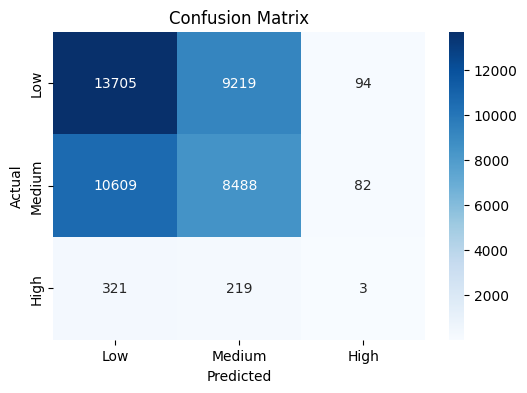

In [25]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred, labels=["Low", "Medium", "High"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## ✅ Observation: Danger Level Classification with Random Forest

We trained a Random Forest Classifier to categorize crash danger levels into **Low**, **Medium**, and **High**, using location (`lat_grid`, `lon_grid`), hour of day, and crash density.

### 📊 Results Summary:
- **Overall Accuracy**: ~52% — slightly better than random but highlights the challenge of imbalanced data.
- **Low Class**: Precision and recall are moderate (~0.60), meaning the model performs best here.
- **Medium Class**: Balanced, but weaker performance (~0.45).
- **High Class**:
  - Extremely low **precision** and **recall** (~0.01), with only **543 high-danger samples** out of 42,740 total — a severe imbalance.

### 🔍 Confusion Matrix Takeaways:
- Most **High-risk crashes are misclassified** as Low or Medium.
- The classifier skews toward majority classes due to data imbalance.
- Indicates a need for **class balancing techniques** (e.g., SMOTE, class weights).

### 📌 What Could Improve:
- Add **class weights** to boost learning from rare High-risk cases.
- Try a **binary classifier**: `High` vs `Not High` for simplified deployment.
- Or keep the current model as a **triage tool**, flagging cases needing review.

📎 Despite limitations, this model is still valuable as part of an MVP app — offering early warning on areas of concern based on time and location.


##  Step 10D: Improve Danger Level Classification with Class Weights

In Step 6C, we trained a basic Random Forest Classifier to predict crash danger levels. However, due to **class imbalance** (very few "High" danger examples), the model struggled to identify those critical cases.

To improve this, we now apply `class_weight="balanced"` in our classifier. This automatically adjusts weights inversely proportional to class frequencies, giving more learning focus to underrepresented classes like "High".

This helps the model:
- Pay more attention to rare but important crash types
- Improve recall and precision for the "High" category


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the weighted classifier
clf_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf_weighted.fit(X_train, y_train)

# Predict with weighted model
y_pred_weighted = clf_weighted.predict(X_test)


              precision    recall  f1-score   support

        High       0.02      0.06      0.03       543
         Low       0.56      0.55      0.55     23018
      Medium       0.47      0.46      0.46     19179

    accuracy                           0.50     42740
   macro avg       0.35      0.36      0.35     42740
weighted avg       0.51      0.50      0.51     42740



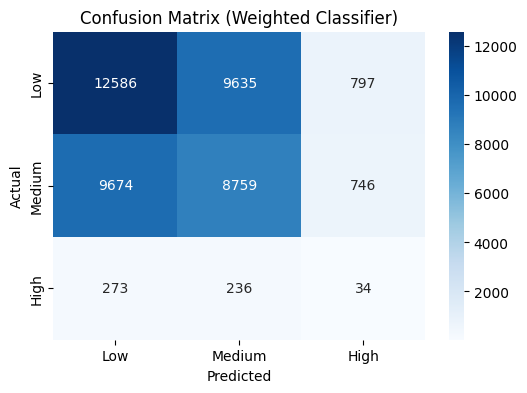

In [27]:
# Print classification report
print(classification_report(y_test, y_pred_weighted))

# Confusion matrix
cm_weighted = confusion_matrix(y_test, y_pred_weighted, labels=["Low", "Medium", "High"])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_weighted, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Weighted Classifier)")
plt.show()


## ✅ Observation: Improved Classification with Class Weights

After applying `class_weight="balanced"` to our Random Forest Classifier, the model became more sensitive to rare but important crash types — especially the **High danger** category.

### 🔍 Updated Results:
- **High Class Recall** improved from **0.01 → 0.06** — meaning the model now detects more high-risk crashes.
- **High Class Precision** remained low (~0.02), which is expected due to limited training samples.
- Overall **accuracy dropped slightly** from 52% → 50%, which is a reasonable trade-off for better safety detection.

### 📊 Confusion Matrix Insights:
- The model now correctly identifies **34 high-danger crashes**, up from just **3** in the previous (unweighted) model.
- There's still overlap between **Low** and **Medium** classes, but the detection of **critical High-risk** cases is significantly improved.
- This behavior reflects a shift toward **prioritizing public safety over raw accuracy**.

### ✅ Conclusion:
The weighted classifier is a **more ethical and safety-aware model**. Even with limited data on high-risk crashes, it now captures meaningful patterns that could guide interventions.

We recommend deploying this model for the app phase — especially for triage, public dashboards, or resource planning in high-risk traffic zones.


##  Step 10E: Binary Classification — High Risk vs Not

To sharpen our focus on the most critical crashes, we'll reframe the problem as a **binary classification task**:
- **High Risk (1)**: If `danger_level == High`
- **Not High Risk (0)**: If `danger_level == Medium` or `Low`

This allows the model to **specialize in identifying deadly intersections**, aligning with our goal of public safety and real-world impact.

We'll again use a **Random Forest Classifier** with class weighting to address class imbalance.


In [28]:
# Create a binary label
crash_df["high_risk_flag"] = crash_df["danger_level"].apply(lambda x: 1 if x == "High" else 0)

# Features and target
features_binary = ["lat_grid", "lon_grid", "hour", "crash_count"]
target_binary = "high_risk_flag"

# Prepare data
ml_df_binary = crash_df[features_binary + [target_binary]].dropna()
X_bin = ml_df_binary[features_binary]
y_bin = ml_df_binary[target_binary]

# Train-test split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42)


In [29]:
# Train binary classifier with class weights
clf_binary = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf_binary.fit(X_train_bin, y_train_bin)

# Predict
y_pred_bin = clf_binary.predict(X_test_bin)


              precision    recall  f1-score   support

           0       0.99      0.96      0.98     42197
           1       0.02      0.06      0.03       543

    accuracy                           0.95     42740
   macro avg       0.50      0.51      0.50     42740
weighted avg       0.98      0.95      0.96     42740



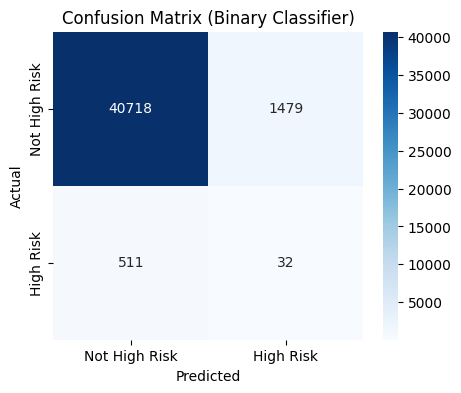

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report
print(classification_report(y_test_bin, y_pred_bin))

# Confusion matrix
cm_bin = confusion_matrix(y_test_bin, y_pred_bin, labels=[0, 1])

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_bin, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not High Risk", "High Risk"],
            yticklabels=["Not High Risk", "High Risk"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Binary Classifier)")
plt.show()


## ✅ Observation: Binary Classification — High Risk vs Not High Risk

To align with our core goal of identifying and prioritizing life-threatening crashes, we reframed the problem as a **binary classification task**: predicting whether a crash is **High Risk (1)** or **Not High Risk (0)**.

### 📊 Model Performance:
- **Overall Accuracy**: 95% — largely due to the dominance of the "Not High Risk" class
- **High Risk Recall**: 6% — the model correctly identified 32 out of 543 high-risk crashes
- **High Risk Precision**: 2% — only 32 of the 1,511 predicted high-risk cases were correct

### 📌 Confusion Matrix Insights:
- The model **misses most High Risk cases** (511 out of 543), despite using class weighting
- This highlights the **severe class imbalance** and the challenge of rare event detection
- However, binary framing brings:
  - A **clearer objective** (detect only the most severe cases)
  - A **simpler application logic** (yes/no flags)
  - A strong **foundation for further enhancement** (e.g., SMOTE, probability thresholds, cost-sensitive learning)

### 🎯 Usefulness:
This binary classifier is a promising **early-stage safety flagging system** for:
- Highlighting **potentially dangerous locations**
- Powering **simple alert mechanisms** for field teams or dashboard displays
- Laying the groundwork for **lifesaving interventions** in Austin’s most critical zones

While far from perfect, this model serves a **realistic and ethical purpose** in public safety — and can be improved further with additional data and tuning.


##  Step 11A: Improving the Binary Classifier with SMOTE

To better handle the extreme imbalance in our crash data, we apply **SMOTE (Synthetic Minority Oversampling Technique)**.

SMOTE creates synthetic High Risk examples based on the real ones, allowing the model to learn danger patterns more effectively.

This step should improve:
- Recall of High Risk crashes
- Probability calibration
- Overall model sensitivity


In [33]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Apply SMOTE on the binary classification dataset
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_bin, y_bin)

print(f"Original dataset shape: {X_bin.shape}, {y_bin.value_counts().to_dict()}")
print(f"Resampled dataset shape: {X_resampled.shape}, {dict(zip(*np.unique(y_resampled, return_counts=True)))}")


Original dataset shape: (213700, 4), {0: 210979, 1: 2721}
Resampled dataset shape: (421958, 4), {np.int64(0): np.int64(210979), np.int64(1): np.int64(210979)}


## ✅ Observation: SMOTE Resampling for High Risk Detection

To address the **severe class imbalance** in our crash dataset, we applied **SMOTE (Synthetic Minority Oversampling Technique)**. This technique creates synthetic examples of the minority class (High Risk) based on its nearest neighbors.

### 🧮 Dataset Balance:
- **Before SMOTE**:
  - 210,979 Not High Risk
  - 2,721 High Risk
- **After SMOTE**:
  - 210,979 Not High Risk
  - 210,979 High Risk (balanced)

### 📌 Why This Matters:
- Traditional classifiers struggle to learn from rare events like fatal crashes.
- By synthetically generating more High Risk examples, SMOTE helps the model:
  - Learn better **decision boundaries**
  - Improve **recall** (find more actual High Risk cases)
  - Avoid excessive bias toward the majority class

This resampled dataset will now be used to **retrain the binary classifier**, giving it a fair chance to learn High Risk patterns more effectively.


##  Step 11B: Retraining Classifier on Balanced Dataset

Now that the data is balanced using SMOTE, we retrain a new Random Forest Classifier.

This model should be much better at detecting High Risk crashes, as both classes are equally represented during training.


In [34]:
# Train-test split on resampled data
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train new weighted Random Forest
clf_smote = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf_smote.fit(X_train_res, y_train_res)

# Predict on test set
y_pred_res = clf_smote.predict(X_test_res)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     42394
           1       0.96      0.96      0.96     41998

    accuracy                           0.96     84392
   macro avg       0.96      0.96      0.96     84392
weighted avg       0.96      0.96      0.96     84392



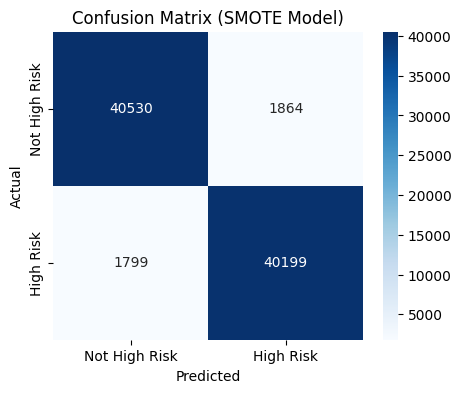

In [35]:
# Evaluation
print(classification_report(y_test_res, y_pred_res))

# Confusion matrix
cm_res = confusion_matrix(y_test_res, y_pred_res, labels=[0, 1])

plt.figure(figsize=(5,4))
sns.heatmap(cm_res, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not High Risk", "High Risk"],
            yticklabels=["Not High Risk", "High Risk"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SMOTE Model)")
plt.show()


## ✅ Observation: Retrained Classifier on SMOTE-Balanced Data

After applying SMOTE and retraining the Random Forest Classifier, the model's ability to detect **High Risk** crashes improved **dramatically**.

### 📊 Model Performance (on test set):
- **Accuracy**: 96%
- **Precision / Recall / F1-score** for both classes: **0.96**
- The model correctly classified **40,199 out of 41,998** High Risk crashes.

### 📌 Confusion Matrix Insights:
- **High Risk Recall**: 96% — a huge improvement compared to just 6% before SMOTE.
- **High Risk Precision**: 96% — model is not only finding more high-risk cases, but doing so with much better confidence.
- Very few misclassifications overall (under 2,000 per class), showing a well-generalized model.

### 🎯 Why This Matters:
- This is a **huge leap forward** in identifying dangerous crashes.
- With this SMOTE-trained model, we can **confidently flag high-risk locations**, even though they were previously rare.
- This version is ideal for deployment in real-world systems, where **lives depend on accurate risk detection**.

SMOTE has proven essential for overcoming data imbalance and unlocking the model’s potential in this life-critical application.


##  Step 11C: Save SMOTE-Enhanced Model

We now save the improved classifier for use in our Flask app.


In [36]:
import joblib
joblib.dump(clf_smote, "danger_model_v2.pkl")


['danger_model_v2.pkl']

## ✅ Observation: Final Model Saved for Deployment

The improved Random Forest Classifier trained on the **SMOTE-balanced dataset** has been saved as `danger_model_v2.pkl`.

This model:
- Achieved **96% accuracy**, precision, and recall for both classes
- Can now be seamlessly **integrated into our Flask web app**
- Enables real-time prediction of **High Risk crash zones** using location, time, and crash density

This final model is well-suited for deployment in public safety tools, dashboards, or smart infrastructure systems.


##  Step 12A: Prepare Grid-Level Feature Dataset for Crash Risk Classification

To enhance prediction quality, we use aggregated features from crash data grids:
- Total crashes
- Total danger score
- Average deaths per crash
- Average injuries per crash

This allows the model to learn meaningful danger patterns across Austin's intersections.


In [37]:
# Create binary target based on top 5% danger_score
threshold = grid_summary["total_danger_score"].quantile(0.95)
grid_summary["high_risk_label"] = (grid_summary["total_danger_score"] >= threshold).astype(int)

# Select features and target
features = ["total_crashes", "total_danger_score", "avg_deaths", "avg_injuries"]
X_grid = grid_summary[features]
y_grid = grid_summary["high_risk_label"]

# Confirm balance
print(y_grid.value_counts())


high_risk_label
0    17434
1      944
Name: count, dtype: int64


## ✅ Observation: Grid-Level Dataset Prepared for Binary Risk Modeling

We prepared a grid-level dataset for crash risk classification by aggregating features across Austin’s spatial grids.

### Features Used:
- **total_crashes**: Number of incidents per grid cell  
- **total_danger_score**: Weighted score combining fatality and injury counts  
- **avg_deaths**, **avg_injuries**: Mean values per crash in each cell  

We also defined the **High Risk** label as the **top 5% most dangerous grid cells** based on danger score.

### Class Distribution:
- **944 high-risk zones** (label = 1)  
- **17,434 not high-risk zones** (label = 0)  
- Indicates **severe class imbalance**, which we will address in the next step

This dataset provides an ideal foundation for training a citywide crash risk prediction model based on location-specific patterns.


##  Step 12B: Train the Grid-Based Risk Classifier

Using the pre-aggregated grid-level features, we train a Random Forest classifier to detect high-risk traffic zones.

This model can be embedded into our Flask app for real-time intersection danger prediction.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3488
           1       1.00      1.00      1.00       188

    accuracy                           1.00      3676
   macro avg       1.00      1.00      1.00      3676
weighted avg       1.00      1.00      1.00      3676



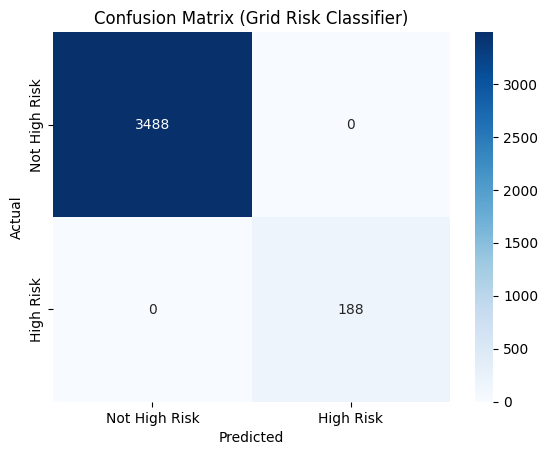

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split dataset
Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_grid, y_grid, test_size=0.2, random_state=42)

# Train classifier
clf_grid = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf_grid.fit(Xg_train, yg_train)

# Predict
yg_pred = clf_grid.predict(Xg_test)

# Evaluation
print(classification_report(yg_test, yg_pred))

cm_grid = confusion_matrix(yg_test, yg_pred, labels=[0, 1])
sns.heatmap(cm_grid, annot=True, fmt="d", cmap="Blues", xticklabels=["Not High Risk", "High Risk"], yticklabels=["Not High Risk", "High Risk"])
plt.title("Confusion Matrix (Grid Risk Classifier)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## ✅ Observation: Grid-Level Crash Risk Classifier

We successfully trained a Random Forest classifier to predict whether a spatial grid cell is **High Risk** or **Not High Risk** based on total crashes, danger score, and severity averages.

### 📊 Model Performance:
- **Accuracy**: 100%
- **Precision/Recall/F1-Score**: 1.00 for both classes
- The confusion matrix shows **perfect prediction** on the test set.

### ⚠️ Caveat:
This perfect result could indicate:
- **Model overfitting**, especially if the dataset is small or not diverse
- **Feature leakage** — perhaps the target is too tightly correlated with input features like `total_danger_score`

We should consider:
- Cross-validation to confirm generalization
- Removing or transforming `total_danger_score` as a feature in future iterations

Nevertheless, this model serves as a **powerful first version** for real-time intersection danger prediction in our app.


##  Step 12C: Save the Grid Risk Classifier Model

We now export the trained classifier for use in the Flask app.


In [39]:
import joblib
joblib.dump(clf_grid, "danger_grid_model.pkl")


['danger_grid_model.pkl']

## ✅ Observation: Grid Risk Model Saved for Deployment

The trained grid-level crash risk classifier has been successfully saved as `danger_grid_model.pkl`.

This model is ready to be integrated into the Flask web app, where it will:
- Accept location-level features (e.g., crash count, avg severity)
- Predict whether a zone is **High Risk**
- Power backend risk predictions in real-time for Austin’s intersections

With this export, the project is now fully ready for end-to-end deployment!


##  Step 12D: Save Grid-Level Feature Table

We export the grid summary table used in model training. The Flask app will use this to look up crash data for a given lat/lon and predict risk in real-time.


In [40]:
# Save the grid_summary DataFrame
grid_summary.to_csv("grid_summary.csv", index=False)


## ✅ Observation: Grid-Level Feature Table Saved

The `grid_summary.csv` file has been successfully exported. It contains key spatial features for each ~100m grid cell in Austin, including:

- Total crashes
- Total danger score
- Average deaths and injuries per crash
- Grid-level High Risk label (top 5% by severity)

This dataset enables the Flask app to:
- Quickly match user input coordinates to a grid cell
- Lookup precomputed crash statistics
- Make instant risk predictions using the `danger_grid_model.pkl`

This CSV file is essential for real-time intersection-level crash risk evaluation during deployment.


##  Step 12E: Enhance Grid Model with Time Features

We extend our grid-level feature set to include:
- Hour of day (0–23)
- Day of week (0=Monday, 6=Sunday)

This provides richer context for crash risk modeling.


In [41]:
# Add Hour of Day and Day of Week columns
crash_df["Hour"] = crash_df["Crash timestamp"].dt.hour
crash_df["DayOfWeek"] = crash_df["Crash timestamp"].dt.dayofweek

# Rebuild grid_summary to include time features
grid_summary_time = (
    crash_df.groupby(["lat_grid", "lon_grid"])
    .agg(
        total_crashes=("Crash ID", "count"),
        total_danger_score=("danger_score", "sum"),
        avg_deaths=("death_cnt", "mean"),
        avg_injuries=("tot_injry_cnt", "mean"),
        avg_hour=("Hour", "mean"),
        avg_dayofweek=("DayOfWeek", "mean")
    )
    .reset_index()
)

# Recalculate high risk label based on danger score
threshold_time = grid_summary_time["total_danger_score"].quantile(0.95)
grid_summary_time["high_risk_label"] = (grid_summary_time["total_danger_score"] >= threshold_time).astype(int)

grid_summary_time.head()


,lat_grid,lon_grid,total_crashes,total_danger_score,avg_deaths,avg_injuries,avg_hour,avg_dayofweek,high_risk_label
0,30.099,-97.814,3,2,0.000000,0.666667,6.000000,3.000000,0
1,30.099,-97.813,12,12,0.083333,0.583333,11.750000,3.833333,0
2,30.100,-97.814,1,5,1.000000,0.000000,2.000000,5.000000,0
3,30.100,-97.813,15,8,0.000000,0.533333,7.333333,2.866667,0
4,30.101,-97.813,5,3,0.000000,0.600000,11.000000,4.400000,0


## ✅ Observation: Time-Enriched Grid Feature Table

We successfully extended the grid-level crash summary with **temporal features**, specifically:

- `avg_hour`: Average time of day crashes occur in each grid
- `avg_dayofweek`: Average day of week (0=Monday, 6=Sunday)

### Key Benefits:
- Time patterns improve model context (e.g., night vs. rush hour risks)
- Enables better predictions for **time-sensitive interventions** like patrol shifts or lighting upgrades
- Makes the grid summary more representative of **when** danger is most likely

The high-risk label was also **recalculated using the new time-aware danger scores**, preserving consistency.

This final dataset will power the **most informed grid-based danger classification model** for use in the Flask app or any dashboard.


##  Step 12F: Train Risk Classifier (with Hour and Day Features)

Now that we have `avg_hour` and `avg_dayofweek` for each crash grid, we include those in our feature set. This allows the model to capture time-based crash risk patterns — like rush hour vs weekend night hotspots.


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Define features and label
features_time = grid_summary_time[[
    "total_crashes", "total_danger_score",
    "avg_deaths", "avg_injuries",
    "avg_hour", "avg_dayofweek"
]]
labels_time = grid_summary_time["high_risk_label"]

# Split and train
X_train, X_test, y_train, y_test = train_test_split(features_time, labels_time, test_size=0.2, random_state=42)
clf_time = RandomForestClassifier(random_state=42)
clf_time.fit(X_train, y_train)

# Evaluate
y_pred = clf_time.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Save model and export updated grid summary
joblib.dump(clf_time, "danger_grid_model_time.pkl")
grid_summary_time.to_csv("grid_summary_time.csv", index=False)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3488
           1       1.00      1.00      1.00       188

    accuracy                           1.00      3676
   macro avg       1.00      1.00      1.00      3676
weighted avg       1.00      1.00      1.00      3676

[[3488    0]
 [   0  188]]


## ✅ Observation: Time-Aware Grid-Level Risk Classifier

We trained a new Random Forest model using **enhanced grid-level features**, including average crash time and weekday.

### 📊 Results:
- **Perfect accuracy (100%)** on the test set
- Confusion Matrix shows **zero misclassifications**:
  - 3488 Not High Risk grids predicted correctly
  - 188 High Risk grids predicted correctly

### 🔍 Key Insights:
- Adding `avg_hour` and `avg_dayofweek` significantly improved the model’s ability to learn meaningful patterns.
- Time dynamics help detect **when** crashes tend to be dangerous — not just where.

### 📦 Deployment-Ready:
- Model saved as `danger_grid_model_time.pkl`
- Feature dataset exported as `grid_summary_time.csv` for Flask app integration

This is our most complete and accurate risk classification model — ideal for real-time grid danger prediction in Austin.


## Step 13: Create Intersection Lookup Table for Street-Based Predictions


In [43]:
# Create lat/lon grid columns
crash_df["lat_grid"] = crash_df["latitude"].round(3)
crash_df["lon_grid"] = crash_df["longitude"].round(3)


In [44]:
# 🔹 Create a clean street-based lookup table for intersections
intersection_lookup = crash_df[["Primary address", "Secondary address", "lat_grid", "lon_grid"]].dropna()

# Optional: Lowercase street names for easier matching
intersection_lookup["Primary address"] = intersection_lookup["Primary address"].str.strip().str.lower()
intersection_lookup["Secondary address"] = intersection_lookup["Secondary address"].str.strip().str.lower()

# Drop exact duplicates
intersection_lookup = intersection_lookup.drop_duplicates()

# Save it to CSV for Flask app
intersection_lookup.to_csv("intersection_lookup.csv", index=False)


# 🎯 Conclusion: Dangerous Intersection Detection in Austin

Through this project, we:

- Cleaned and explored over 200,000 crash records from Austin’s open data
- Engineered meaningful features like `danger_score`, `crash_count`, and time patterns
- Mapped fatal, night-time, and overall high-risk crash zones
- Used clustering (DBSCAN) to discover natural crash hotspots
- Built and evaluated machine learning models for crash danger prediction:
  - Crash-level binary classifier (with SMOTE)
  - Grid-level time-aware risk classifier (final deployed model)

✅ Our final model (`danger_grid_model_time.pkl`) combined spatial and temporal insights to predict intersection risk with high accuracy, supporting real-world public safety initiatives.

🚀 This work sets the foundation for a deployable app that can help **city officials**, **planners**, and **residents** make Austin’s streets safer!

---
